# Data Mining Project

## Part 1 - Exploratory Data Analysis

### Import required libraries

In [2]:
from tabulate import tabulate

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

### Import the dataset and show its characteristics

We can see that the dataset comprises **41188 entries** and **20 columns of features** plus the last column that represents the class of each input, either yes or no.
From what we can see with the first entry, there seems to be multiple quantitative and qualitative features, mostly continous and nominal features. There doesn't seem to be missing values in the dataset.

In [25]:
data = pd.read_csv('data/bank-additional-full.csv', delimiter=';')

print(f"{data.shape[0]} inputs, {data.shape[1]-1} features and {len(np.unique(data['y']))} classes\n")
print(data.columns)

print('\nAn example of entry :')
print(data.loc[0])

print(f'There are {data.isna().sum().sum()} missing values in the dataset')

41188 inputs, 20 features and 2 classes

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

An example of entry :
age                        56
job                 housemaid
marital               married
education            basic.4y
default                    no
housing                    no
loan                       no
contact             telephone
month                     may
day_of_week               mon
duration                  261
campaign                    1
pdays                     999
previous                    0
poutcome          nonexistent
emp.var.rate              1.1
cons.price.idx         93.994
cons.conf.idx           -36.4
euribor3m               4.857
nr.employed            5191.0
y                          no
Name: 0, dt

In [3]:
for feature in data.columns:
    feat_type = type(data[feature][0])
    print(f'{feature} is of type {feat_type}', end='')
    
    if feat_type == str :
        unique_feat = np.unique(data[feature])
        print(f' and comprised of {len(unique_feat)} unique element : {unique_feat}', end='')
    
    print('')

age is of type <class 'numpy.int64'>
job is of type <class 'str'> and comprised of 12 unique element : ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
marital is of type <class 'str'> and comprised of 4 unique element : ['divorced' 'married' 'single' 'unknown']
education is of type <class 'str'> and comprised of 8 unique element : ['basic.4y' 'basic.6y' 'basic.9y' 'high.school' 'illiterate'
 'professional.course' 'university.degree' 'unknown']
default is of type <class 'str'> and comprised of 3 unique element : ['no' 'unknown' 'yes']
housing is of type <class 'str'> and comprised of 3 unique element : ['no' 'unknown' 'yes']
loan is of type <class 'str'> and comprised of 3 unique element : ['no' 'unknown' 'yes']
contact is of type <class 'str'> and comprised of 2 unique element : ['cellular' 'telephone']
month is of type <class 'str'> and comprised of 10 unique element : ['apr' 'aug' 'de

Even if there is no missing values in the dataset, there are **'unknown' entries** for features 'default' and 'housing' that represents a non-negligible part of the 41188 entries.

In [4]:
print(f"There are {(data['default']=='unknown').sum()} 'unknown' in 'default' and {(data['housing']=='unknown').sum()} 'unknown' in 'housing'")

There are 8597 'unknown' in 'default' and 990 'unknown' in 'housing'


We can also observe the fact that the **data is not balanced** with approximately **11% of positive cases** and **89% of negative cases**, we will need to take that into account for the classification

In [5]:
n_yes = (data['y']=='yes').sum()
n_no = (data['y']=='no').sum()

print(f'Out of {data.shape[0]} examples, there are {n_yes} positive outcomes and {n_no} negative outcomes so the yes class is {n_yes*100/data.shape[0]:.2f}% of all examples')

Out of 41188 examples, there are 4640 positive outcomes and 36548 negative outcomes so the yes class is 11.27% of all examples


### Analysis of individual variables

1) Numerical variable

In [5]:
numerical_feat = data.select_dtypes(include=[np.int64, np.float64])
print(numerical_feat.columns.to_numpy())

['age' 'duration' 'campaign' 'pdays' 'previous' 'emp.var.rate'
 'cons.price.idx' 'cons.conf.idx' 'euribor3m' 'nr.employed']


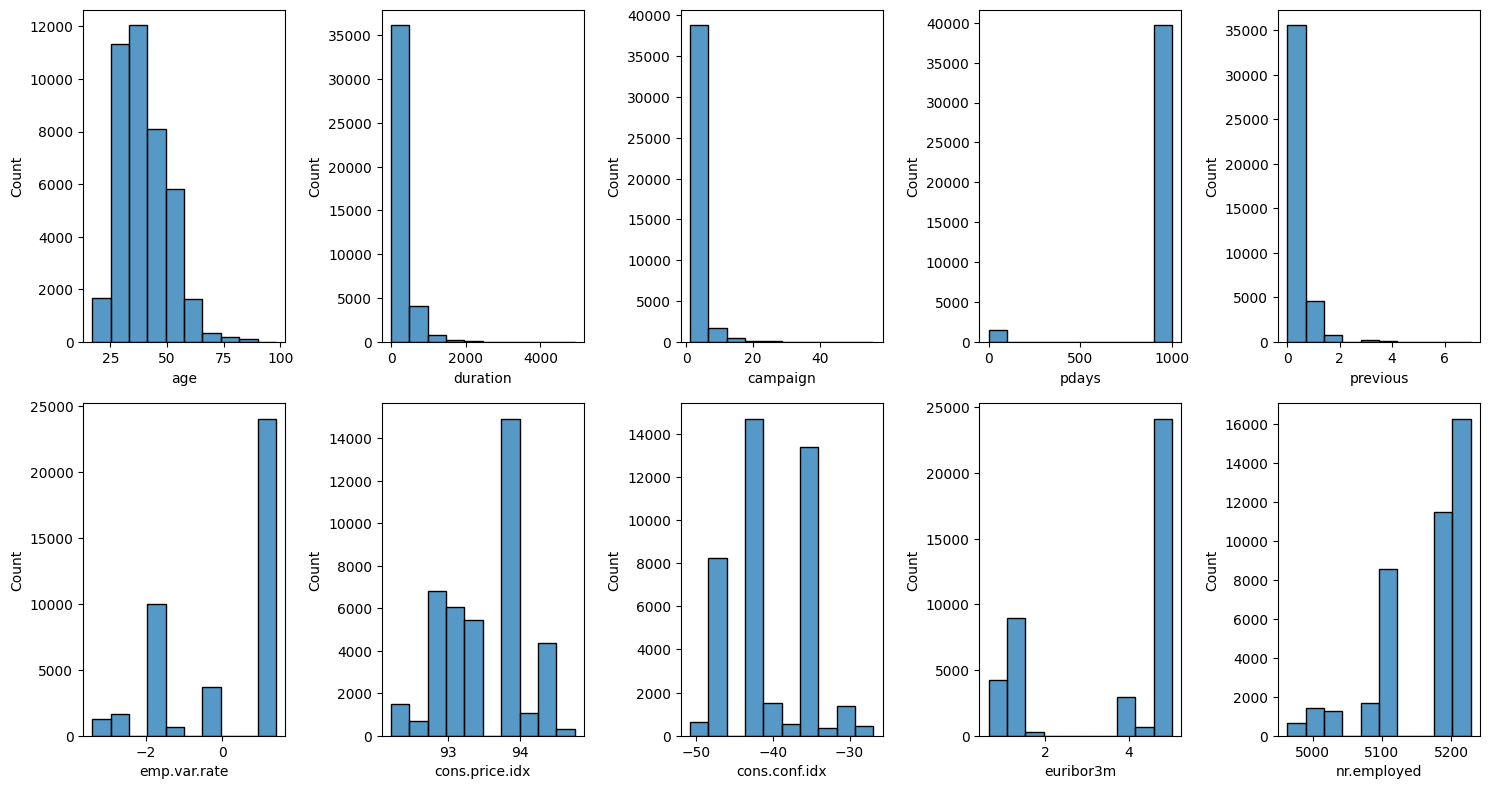

In [10]:
plt.rcParams['figure.figsize'] = [15, 8]
fig, axes = plt.subplots(2, 5)
for i, (x, y) in enumerate(list(itertools.product([0,1], [0,1,2,3,4]))):
    sns.histplot(data=data[numerical_feat.columns[i]], ax=axes[x, y], bins=10)
plt.tight_layout()

We can see that pdays is split between values smaller than 100 and other values that represents the majority of entries where pdays=999. This is because 999 is used when the client has never been called before. We will need to modify that before proceeding

There will be a need to standardize/normalize the data as the ranges of values are very different from one feature to another

We mostly get asymetric distributions

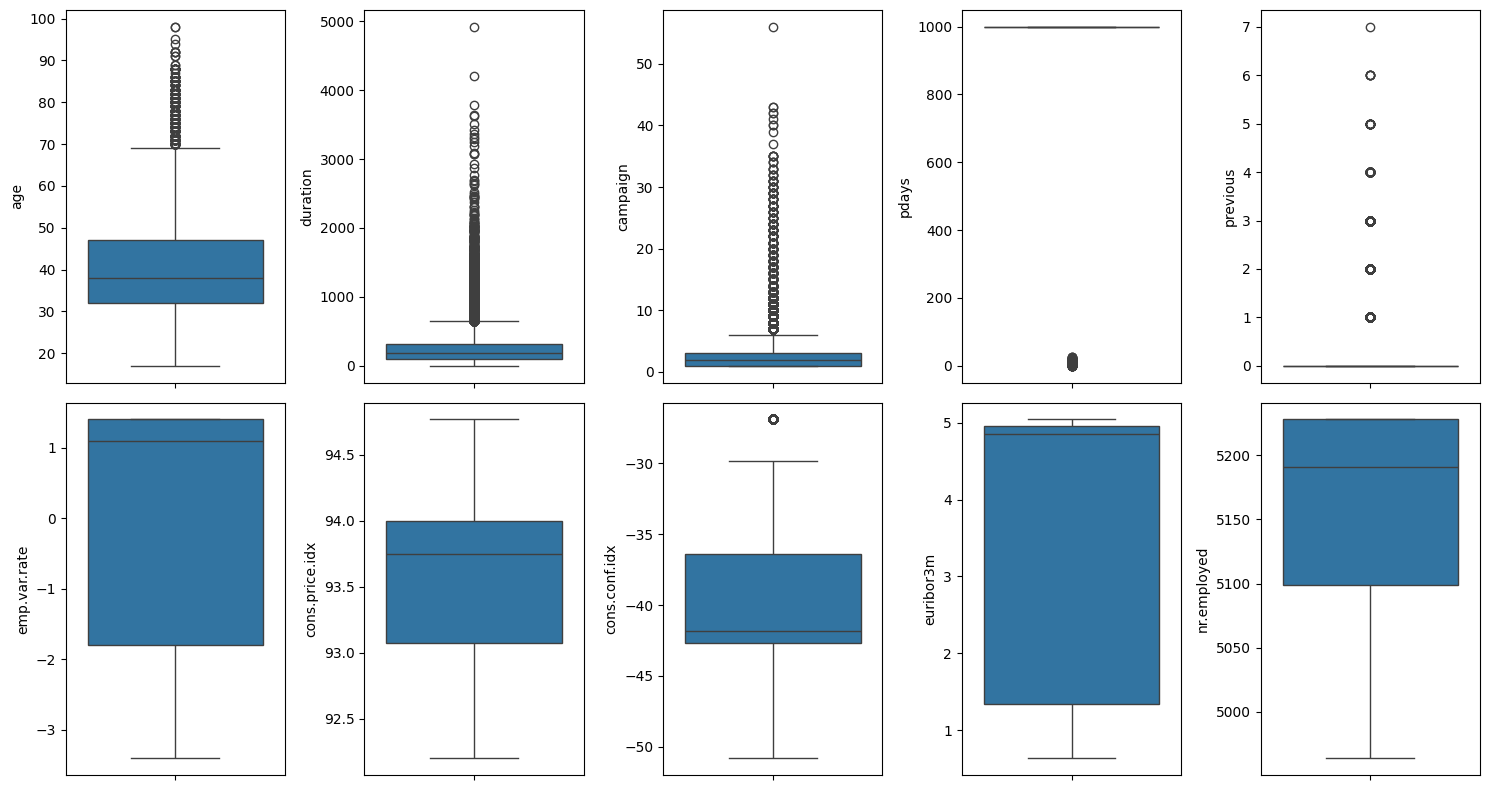

In [8]:
fig, axes = plt.subplots(2, 5)
for i, (x, y) in enumerate(list(itertools.product([0,1], [0,1,2,3,4]))):
    sns.boxplot(data=data[numerical_feat.columns[i]], ax=axes[x, y])
plt.tight_layout()

We get a lot of "outliers" on duration and campaign features as these values are quite small for the vast majority of client.
However, these don't seem like "wrong" values or errors as it is possible that some clients had long conversations or were contacted a lot of times if the campaign lasted a long time.
We get the same problem with previous were the majority of clients weren't contacted before but it doesn't mean that the ones who were are wrong entries.

So we won't delete these outliers as they seem like normal values and not errors. The same can be said about the age feature as there are no shocking values with the largest being 98 years old.

The problem with pdays feature was discussed before so its plot isn't really interesting to watch.

We can see a data point shown as an outlier on cons.conf.idx. As it is the only one, we may erase this entry before classification as it won't impact the data comprised of 41188 entries

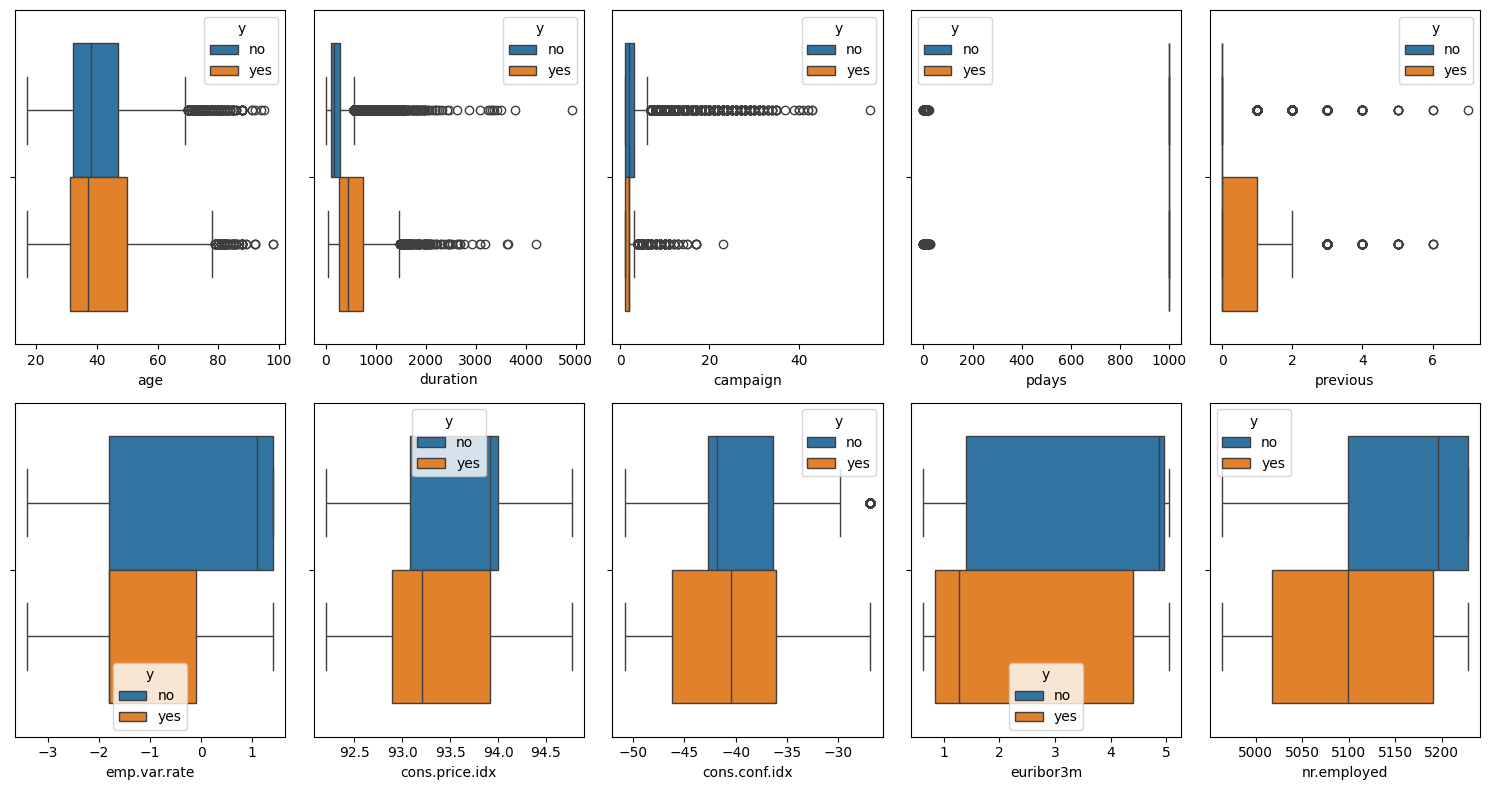

In [11]:
fig, axes = plt.subplots(2, 5)
for i, (x, y) in enumerate(list(itertools.product([0,1], [0,1,2,3,4]))):
    sns.boxplot(x=data[numerical_feat.columns[i]], ax=axes[x, y], hue=data['y'])
plt.tight_layout()

By grouping with the class, we observe small differences for the majority of features. We can still observe some difference on the median for euribor3m and cons.price.idx. nr.employed also seems to have some discriminative abilities.

The duration feature seems to be the best to discriminate with a clear separation of the boxplots for both classes.

2) Categorical values

In [39]:
categorical_feat = data.select_dtypes(include=object)
print(categorical_feat.columns.to_numpy())

['job' 'marital' 'education' 'default' 'housing' 'loan' 'contact' 'month'
 'day_of_week' 'poutcome' 'y']


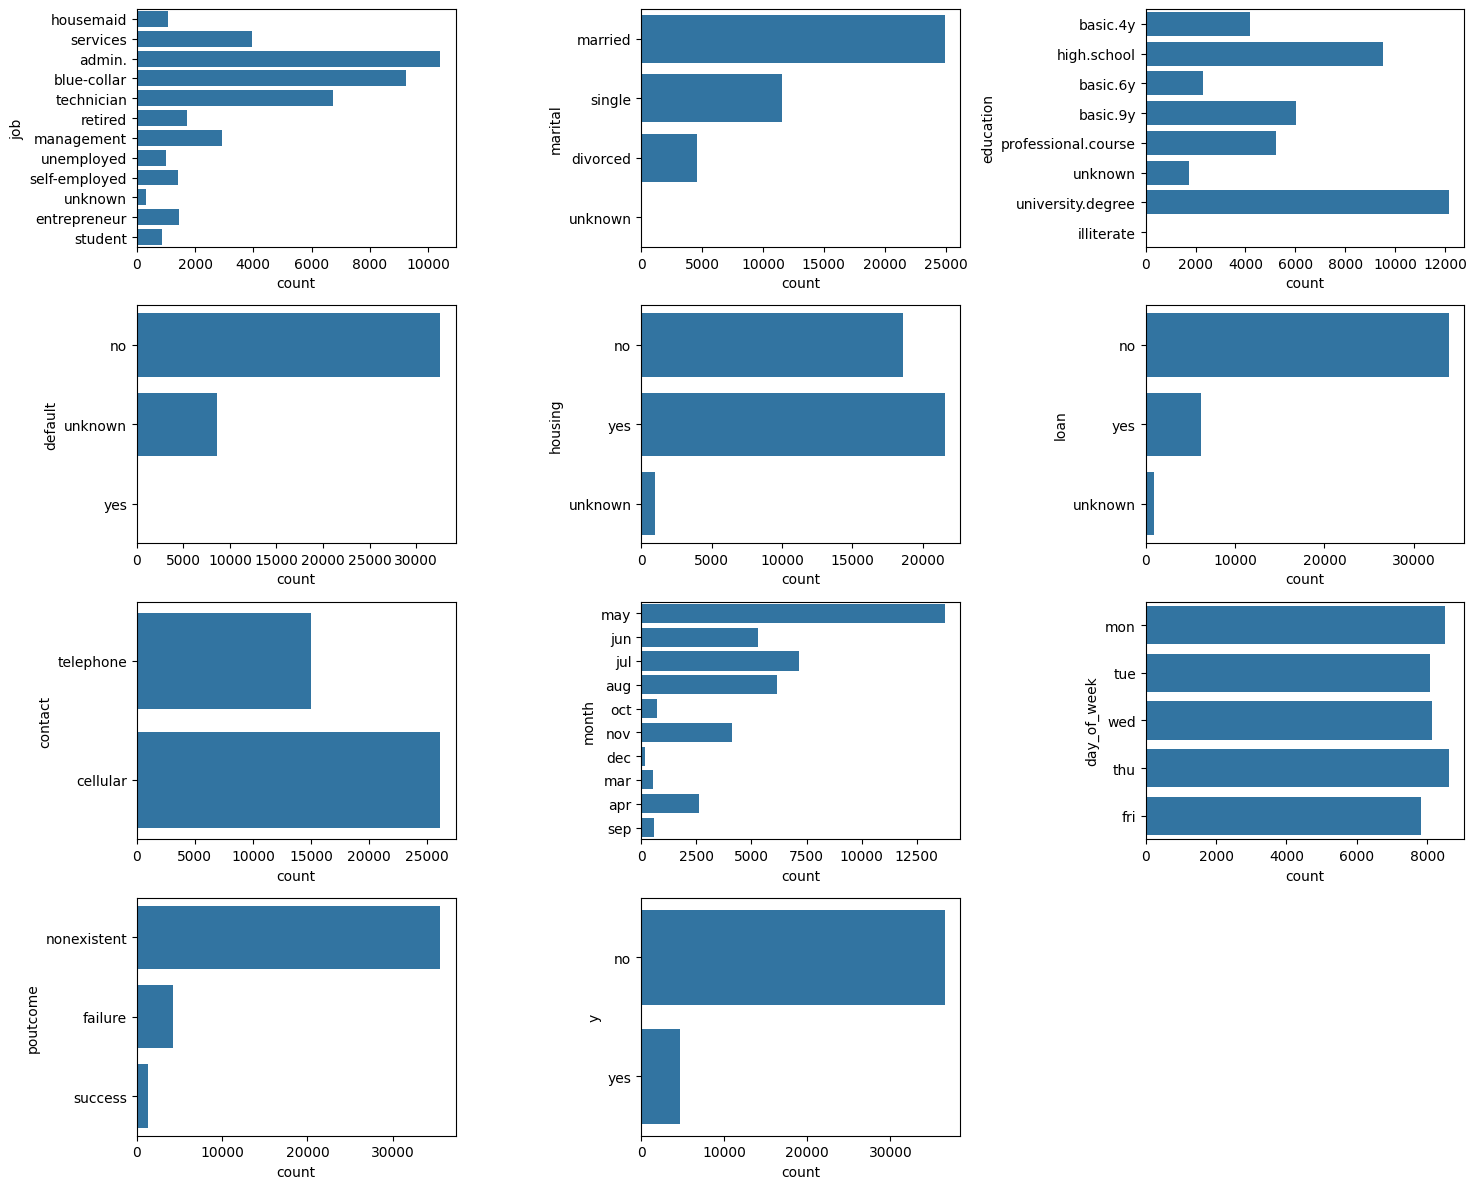

In [10]:
plt.rcParams['figure.figsize'] = [15, 12]
fig, axes = plt.subplots(4, 3)
for i, (x, y) in enumerate(list(itertools.product([0,1,2,3], [0,1,2]))):
    sns.countplot(data=data[categorical_feat.columns[i]], ax=axes[x, y])
    
    if i == 10:
        axes[-1, -1].axis('off')
        break
plt.tight_layout()

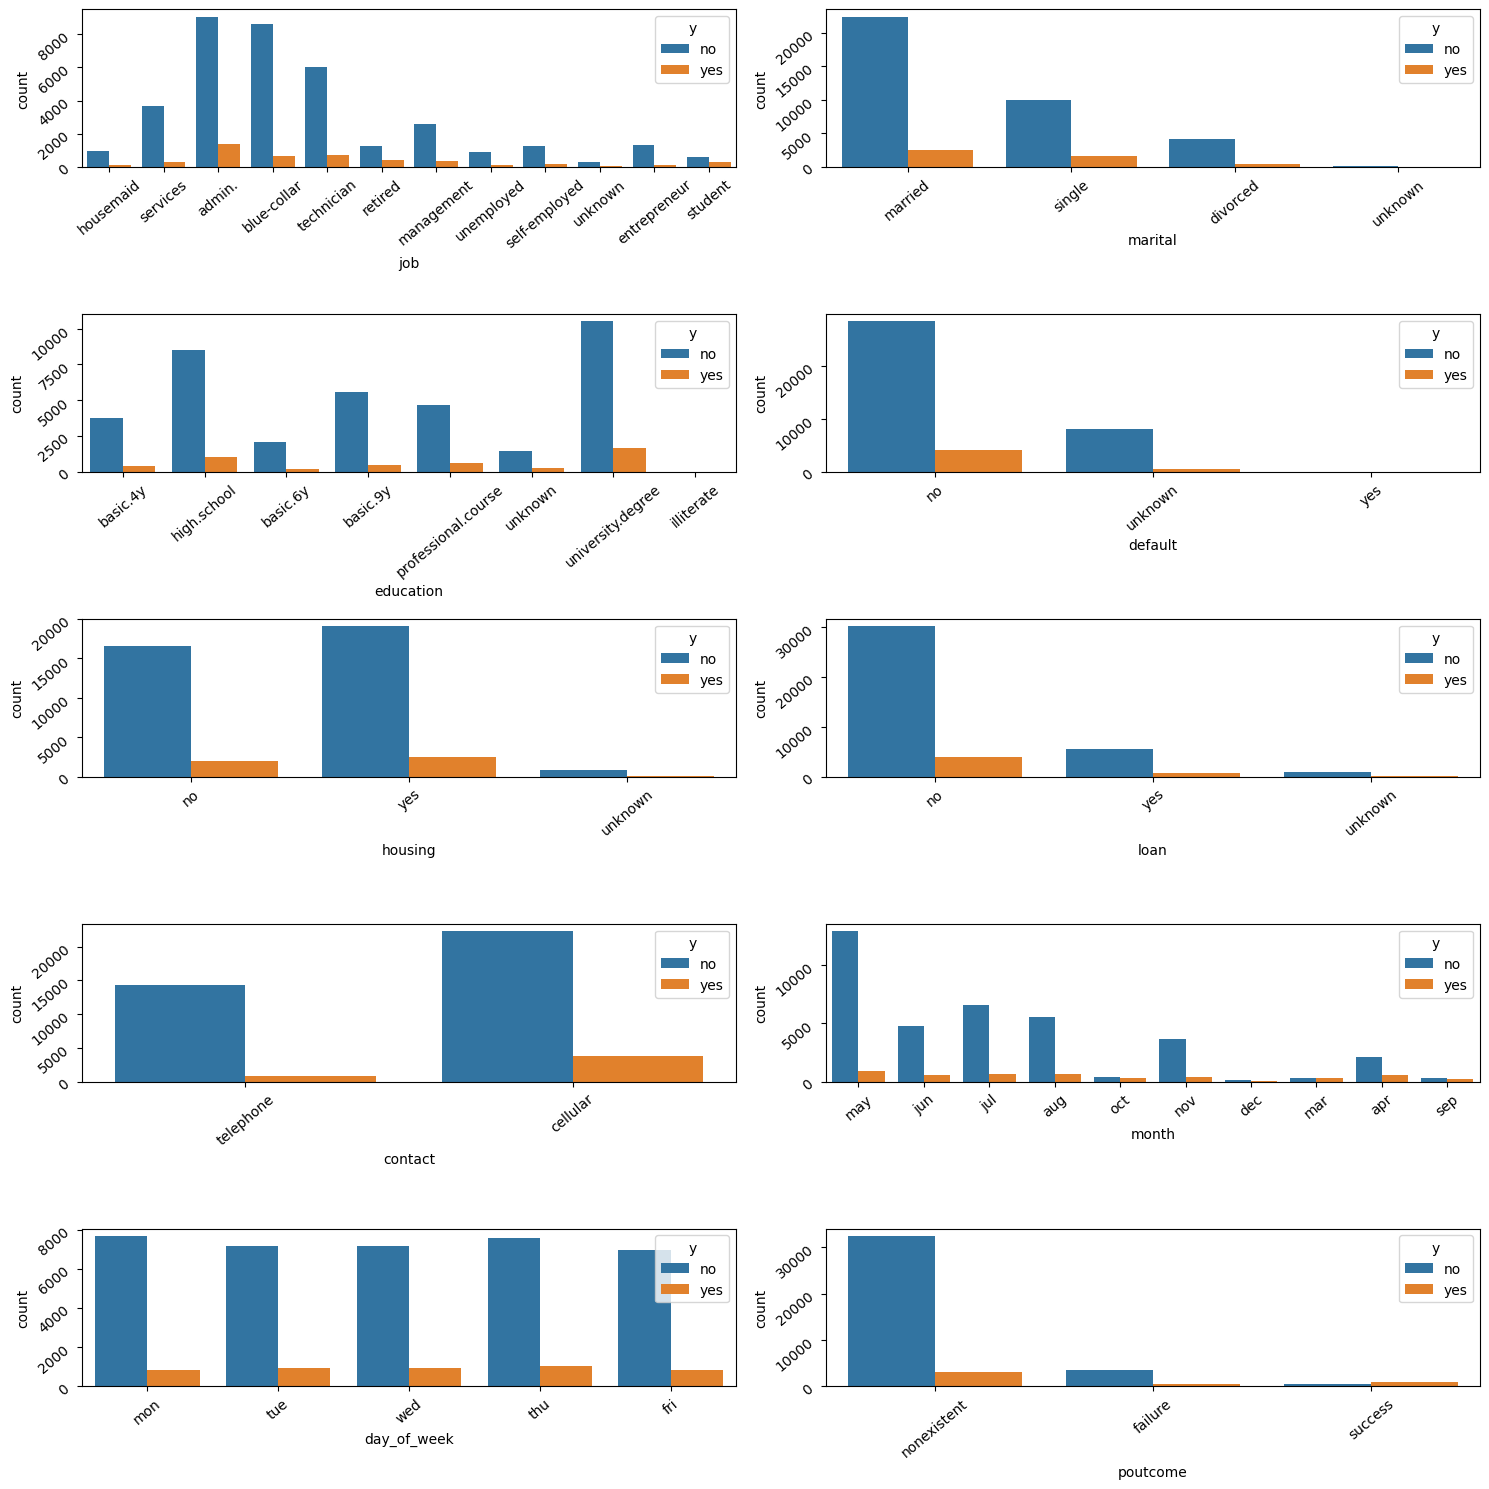

In [24]:
plt.rcParams['figure.figsize'] = [15, 15]
fig, axes = plt.subplots(5, 2)
for i, (x, y) in enumerate(list(itertools.product([0,1,2,3,4], [0,1]))):
    sns.countplot(x=data[categorical_feat.columns[i]], hue=data['y'], ax=axes[x, y])
    axes[x,y].tick_params(labelrotation=40)
plt.tight_layout()

The first graph shows us the imbalance of the class labels with the vast majority being no

We can think that day_of_week doesn't seem to bring much to the table as the ratio yes/no seems to be the same for each day. We'll confirm it later but it may be a feature that we can delete.

Other features seems to show some variability with different frequency for categories and different ratios of yes/no for those categories

### Analysis of relationship between variables

1) Correlation matrix

<Axes: >

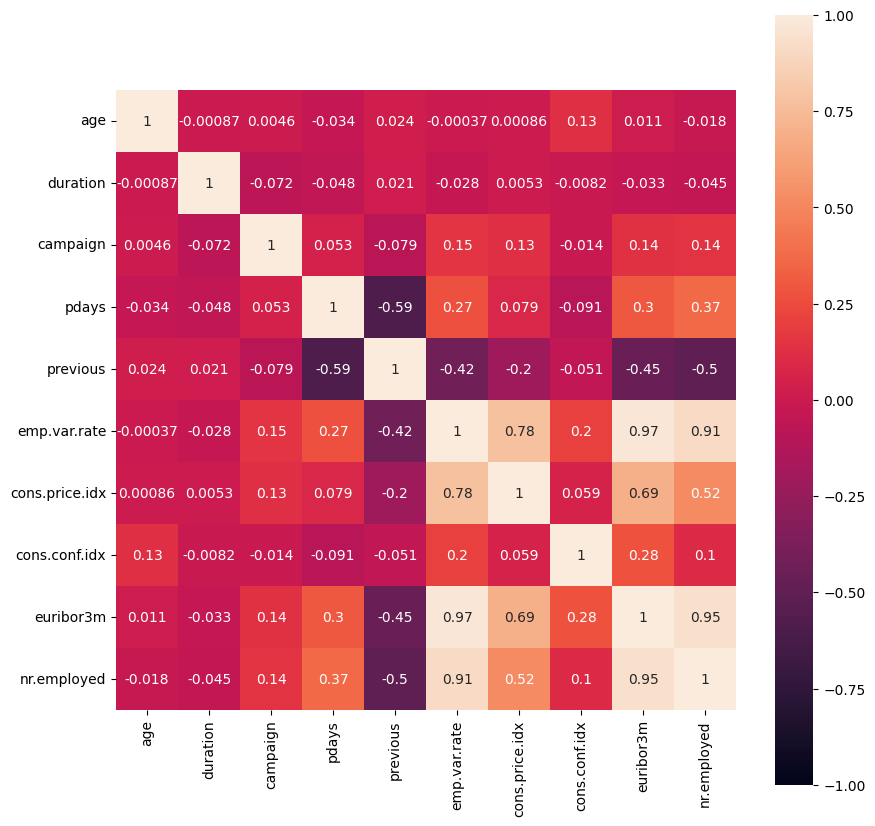

In [38]:
plt.rcParams['figure.figsize'] = [10, 10]
correlation = numerical_feat.corr(method='pearson')
sns.heatmap(correlation, annot=True, square=True, vmin=-1, vmax=1)

We can observe that most of the features aren't correlated.
 
However there exist very strong correlation between emp.var.rate, nr.employed and euribor3m with coefficients greater than 0.9.
There is also correlation between these three categories and cons.price.idx but it is a little bit smaller.

There is also non-negligible inverse correlation between previous and pdays.

2) Calculating Cramér's V for categorical data

In [68]:
# The following correction from cramers' v was taken from the following page :
# https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [80]:
cat_feat_list = categorical_feat.columns.to_numpy()[:-1]
n = len(cat_feat_list)
cramersv_matrix = np.zeros((n, n))

for i, feat1 in enumerate(cat_feat_list):
    for j, feat2 in enumerate(cat_feat_list):
        cramers_v = cramers_corrected_stat(pd.crosstab(data[feat1], data[feat2]))
        cramersv_matrix[i, j] = cramers_v
        
print(tabulate(np.concatenate((cat_feat_list.reshape(-1,1),cramersv_matrix), axis=1), headers=[""]+cat_feat_list))

                   job     marital    education     default     housing        loan    contact      month    day_of_week    poutcome
-----------  ---------  ----------  -----------  ----------  ----------  ----------  ---------  ---------  -------------  ----------
job          1          0.18359       0.359526   0.152101    0.0106304   0.0102178   0.127856   0.109835      0.0164577    0.0995598
marital      0.18359    1             0.11624    0.0954341   0.00916995  0           0.0719935  0.0501735     0.0108883    0.0366305
education    0.359526   0.11624       1          0.170355    0.013316    0           0.123302   0.0947177     0.0197251    0.0422816
default      0.152101   0.0954341     0.170355   1           0.0105731   0.00156678  0.135554   0.111926      0.0113136    0.0766283
housing      0.0106304  0.00916995    0.013316   0.0105731   1           0.707852    0.0846035  0.0542431     0.0146348    0.0169577
loan         0.0102178  0             0          0.00156678  0.707852

We can observe a correlation between housing and loan, but also between month and contact. There is also a weaker correlation between education and job

### Preparation of the data

For classification we'll want to try different subset of features, we will prepare the different subsets that we will use in this part.
First we'll do some modifications that we'll use every time.

We saw that pdays is split between client that have never been called (999) and client called in the last 100 days. We'll transform this feature to a binary feature was_called_before

In [36]:
pdays = data['pdays'].copy()
pdays[pdays!=999] = 1
pdays[pdays==999] = 0
data['pdays'] = pdays
data = data.rename(columns={'pdays':'was_called_before'})
print(np.sum(data['was_called_before']==0), np.sum(data['was_called_before']==1))

39673 1515


In the first dataset we'll use, we will just convert categorical variables with one-hot encoding.
There is a logical ordering in education so could just use a label encoder with values from 1 to 8 but there is also an unknown value so we'll just use one hot encoding for it too

In [81]:
data_1 = data.copy()
var_to_dummies = categorical_feat.columns.to_list()
var_to_dummies.remove('y')
var_to_dummies.remove('contact') # is binary, so we only need one column for it

data_1 = pd.get_dummies(data_1, columns=var_to_dummies, dtype=int) # 1-hot encoding
data_1.replace({'cellular':0, 'telephone':1}, inplace=True) # binary variable
data_1.replace({'no':0, 'yes':1}, inplace=True) # we also encode y as int
data_1 = data_1[[c for c in data_1 if c != 'y'] + ['y']] # we put y at the end
print(data_1.shape, data_1.columns)

# We apply normalization to numerical features
cols_to_norm = numerical_feat.columns.to_list()
cols_to_norm.remove('pdays') # we converted it to binary

data_1[cols_to_norm] = data_1[cols_to_norm].apply(lambda x: (x-x.mean())/x.std())

data_1.to_csv('data/data_subset_1.csv', index=None)

(41188, 63) Index(['age', 'contact', 'duration', 'campaign', 'was_called_before',
       'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'marital_unknown', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'month_apr',
       'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'm

In a second subset of data, we'll use our EDA to make some changes.
We saw high correlation between emp.var.rate, nr.employed, euribor3m and cons.price.idx.
emp.var.rate has the biggest correlartion with all three, so we'll only keep this one. We will also delete day_of_week that doesn't bring anything

In [85]:
day_of_week_cols = [c for c in data_1.columns if 'day_of_week' in c]
data_2 = data_1.drop(columns=['euribor3m', 'cons.price.idx', 'nr.employed']+day_of_week_cols)
data_2.to_csv('data/data_subset_2.csv', index=None)
print(data_2.shape)

(41188, 55)
